# Initialization

In [1]:
# https://github.com/ray-project/ray/blob/master/rllib/examples/sb2rllib_rllib_example.py
import ray
from ray import tune, air
import ray.rllib.algorithms.ppo as ppo

In [2]:
if ray.is_initialized():
    ray.shutdown()
ray.init(num_gpus=1, local_mode=False)

Usage stats collection is enabled by default for nightly wheels. To disable this, run the following command: `ray disable-usage-stats` before starting Ray. See https://docs.ray.io/en/master/cluster/usage-stats.html for more details.


2023-01-10 18:04:07,658	INFO worker.py:1536 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.8.15
Ray version:,3.0.0.dev0
Dashboard:,http://127.0.0.1:8265


In [3]:
# settings used for both stable baselines and rllib
import gymnasium as gym
import platoonenv
# import check env

env_name = "Platoon-v2"
env = gym.make(env_name)

print(env_name,"\n------------------")
print("reward_threshold", env.spec.reward_threshold)
print("max_episode_steps", env.spec.max_episode_steps)

Platoon-v2 
------------------
reward_threshold 500
max_episode_steps 20


In [4]:
from ray.rllib.utils import check_env

check_env(env)

2023-01-10 18:04:10,795	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.


In [5]:
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.dqn import DQNConfig

config = (
    PPOConfig()
    .environment(env=env_name)
    .framework("torch")
    .rollouts(num_rollout_workers=10)
    # .rollouts(num_rollout_workers=0) # curiosity doesn't support parallelism
    .resources(num_gpus=1)
    # .exploration( # https://docs.ray.io/en/latest/rllib/rllib-algorithms.html#curiosity-icm-intrinsic-curiosity-module
    #     exploration_config={
    #         "type": "Curiosity",  # <- Use the Curiosity module for exploring.
    #         "eta": 1.0,  # Weight for intrinsic rewards before being added to extrinsic ones.
    #         "lr": 0.001,  # Learning rate of the curiosity (ICM) module.
    #         "feature_dim": 288,  # Dimensionality of the generated feature vectors.
    #         # Setup of the feature net (used to encode observations into feature (latent) vectors).
    #         "feature_net_config": {
    #             "fcnet_hiddens": [],
    #             "fcnet_activation": "relu",
    #         },
    #         "inverse_net_hiddens": [256],  # Hidden layers of the "inverse" model.
    #         "inverse_net_activation": "relu",  # Activation of the "inverse" model.
    #         "forward_net_hiddens": [256],  # Hidden layers of the "forward" model.
    #         "forward_net_activation": "relu",  # Activation of the "forward" model.
    #         "beta": 0.2,  # Weight for the "forward" loss (beta) over the "inverse" loss (1.0 - beta).
    #         # Specify, which exploration sub-type to use (usually, the algo's "default"
    #         # exploration, e.g. EpsilonGreedy for DQN, StochasticSampling for PG/SAC).
    #         "sub_exploration": {
    #             "type": "StochasticSampling",
    #         }
    #     }
    # )
)
config.horizon = env.spec.max_episode_steps
config.lr = 0.0001
config.create_env_on_local_worker=True
algo = config.build()

(RolloutWorker pid=19380) 2023-01-10 18:04:23,167	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
(RolloutWorker pid=19380) 2023-01-10 18:04:23,224	INFO policy.py:1196 -- Policy (worker=1) running on CPU.
(RolloutWorker pid=19380) 2023-01-10 18:04:23,224	INFO torch_policy_v2.py:110 -- Found 1 visible cuda devices.
(RolloutWorker pid=14712) 2023-01-10 18:04:23,271	INFO policy.py:1196 -- Policy (worker=2) running on CPU.
(RolloutWorker pid=14712) 2023-01-10 18:04:23,271	INFO torch_policy_v2.py:110 -- Found 1 visible cuda devices.
(RolloutWorker pid=8636) 2023-01-10 18:04:23,267	INFO policy.py:1196 -- Policy (worker=5) running on CPU.
(RolloutWorker pid=8636) 2023-01-10 18:04:23,267	INFO torch_policy_v2.py:110 -- Found 1 visible cuda devices.
(RolloutWorker pid=9004) 2023-01-10 18:04:23,254	INFO polic

In [6]:
config.to_dict()

{'extra_python_environs_for_driver': {},
 'extra_python_environs_for_worker': {},
 'num_gpus': 1,
 'num_cpus_per_worker': 1,
 'num_gpus_per_worker': 0,
 '_fake_gpus': False,
 'custom_resources_per_worker': {},
 'placement_strategy': 'PACK',
 'eager_tracing': False,
 'eager_max_retraces': 20,
 'tf_session_args': {'intra_op_parallelism_threads': 2,
  'inter_op_parallelism_threads': 2,
  'gpu_options': {'allow_growth': True},
  'log_device_placement': False,
  'device_count': {'CPU': 1},
  'allow_soft_placement': True},
 'local_tf_session_args': {'intra_op_parallelism_threads': 8,
  'inter_op_parallelism_threads': 8},
 'env': 'Platoon-v2',
 'env_config': {},
 'observation_space': None,
 'action_space': None,
 'env_task_fn': None,
 'render_env': False,
 'clip_rewards': None,
 'normalize_actions': True,
 'clip_actions': False,
 'disable_env_checking': False,
 'is_atari': None,
 'num_envs_per_worker': 1,
 'sample_collector': ray.rllib.evaluation.collectors.simple_list_collector.SimpleListCol

In [7]:
from glob import glob
from pathlib import Path
save_dir = Path("saved_models",f"{env_name}-curious-2")
save_dir.mkdir(parents=True, exist_ok=True)
load_checkpoint = True
if load_checkpoint:
    try:
        checkpoint_path = sorted(glob(str(save_dir / "*")))[-1]
        print(f"Restoring from checkpoint: {checkpoint_path}")
        algo.restore(checkpoint_path)
    except IndexError as e:
        print(f"Failed to load checkpoint: {e}")

2023-01-10 18:04:25,422	INFO trainable.py:790 -- Restored on 127.0.0.1 from checkpoint: saved_models\Platoon-v2-curious-2\checkpoint_000077
2023-01-10 18:04:25,423	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 77, '_timesteps_total': None, '_time_total': 805.8298804759979, '_episodes_total': 30760}


Restoring from checkpoint: saved_models\Platoon-v2-curious-2\checkpoint_000077


# Training

In [8]:
from IPython.display import clear_output
def plot(rewards_history):
    clear_output(True)
    plt.figure(figsize=(12, 5))
    plt.title("Training...")
    plt.xlabel("Step")
    plt.ylabel("Rewards")
    plt.plot([x["episode_reward_mean"] for x in rewards_history])
    plt.show()

In [9]:
results_history = []

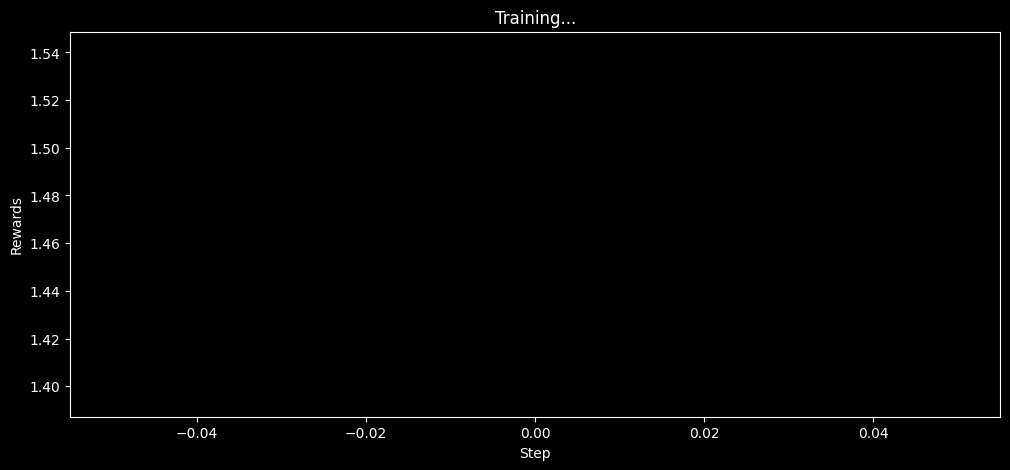

reward mean=1.47: 100%|██████████| 1/1 [00:20<00:00, 20.10s/it]


In [10]:
from tqdm import tqdm
from itertools import count
import matplotlib.pyplot as plt
plot_every = 1
train_steps = 1

with tqdm(total=train_steps) as pbar:
    for i in count() if train_steps == 0 else range(train_steps):
        try:
            results = algo.train()
        except KeyboardInterrupt:
            print("Interrupting training")
            checkpoint_path = algo.save(save_dir)
            print(f"Checkpoint saved at: {checkpoint_path}")
            break
        pbar.set_description(f"reward mean={results['episode_reward_mean']:.02f}")
        results_history.append(results)
        pbar.update()
        if i % plot_every == 0:
            plot(results_history)
            pbar.display()
        

In [11]:
results["info"]

{'learner': {'default_policy': {'custom_metrics': {},
   'learner_stats': {'cur_kl_coeff': 0.6750000000000002,
    'cur_lr': 0.00010000000000000003,
    'total_loss': -0.022744262916967274,
    'policy_loss': -0.0668562723784357,
    'vf_loss': 0.03365269314738051,
    'vf_explained_var': 0.999404497684971,
    'kl': 0.015495284816763972,
    'entropy': 0.6587168878124606,
    'entropy_coeff': 0.0},
   'model': {},
   'num_grad_updates_lifetime': 465.5,
   'diff_num_grad_updates_vs_sampler_policy': 464.5}},
 'num_env_steps_sampled': 312000,
 'num_env_steps_trained': 312000,
 'num_agent_steps_sampled': 312000,
 'num_agent_steps_trained': 312000}

In [12]:
algo.save(save_dir)
# checkpoint path is grabbed by glob when restoring earlier

'saved_models\\Platoon-v2-curious-2\\checkpoint_000078'

# Inspecting

In [13]:
algo.evaluate()

2023-01-10 18:04:45,890	INFO algorithm.py:882 -- Evaluating current policy for 10 episodes.
2023-01-10 18:04:45,891	INFO rollout_worker.py:905 -- Generating sample batch of size 400
2023-01-10 18:04:45,892	INFO sampler.py:610 -- Raw obs from env: { 0: { 'agent0': np.ndarray((20,), dtype=float32, min=-10.0, max=8.0, mean=-0.05)}}
2023-01-10 18:04:45,893	INFO sampler.py:611 -- Info return from env: {0: {'agent0': {}}}
2023-01-10 18:04:45,894	INFO sampler.py:853 -- Preprocessed obs: np.ndarray((20,), dtype=float32, min=-10.0, max=8.0, mean=-0.05)
2023-01-10 18:04:45,895	INFO sampler.py:858 -- Filtered obs: np.ndarray((20,), dtype=float32, min=-10.0, max=8.0, mean=-0.05)
2023-01-10 18:04:45,897	INFO sampler.py:1144 -- Inputs to compute_actions():

{ 'default_policy': [ { 'data': { 'agent_id': 'agent0',
                                  'env_id': 0,
                                  'info': {},
                                  'obs': np.ndarray((20,), dtype=float32, min=-10.0, max=8.0, mea

{'evaluation': {'episode_reward_max': 3.79,
  'episode_reward_min': -1.17,
  'episode_reward_mean': 1.488953168044077,
  'episode_len_mean': 11.0,
  'episode_media': {},
  'episodes_this_iter': 363,
  'policy_reward_min': {},
  'policy_reward_max': {},
  'policy_reward_mean': {},
  'custom_metrics': {},
  'hist_stats': {'episode_reward': [1.94,
    2.73,
    3.36,
    2.22,
    -0.44999999999999996,
    1.96,
    1.43,
    2.27,
    2.77,
    1.32,
    0.8899999999999999,
    2.1100000000000003,
    1.4300000000000002,
    1.06,
    2.07,
    2.91,
    1.26,
    1.91,
    2.87,
    2.69,
    0.9299999999999999,
    1.23,
    1.3499999999999999,
    1.64,
    2.2399999999999998,
    1.52,
    1.28,
    -0.42000000000000004,
    1.8399999999999999,
    2.03,
    0.83,
    2.49,
    -1.02,
    1.52,
    1.6899999999999997,
    0.7499999999999999,
    1.1800000000000002,
    1.5899999999999999,
    1.45,
    2.58,
    0.57,
    1.52,
    2.0700000000000003,
    0.8299999999999998,
    1.95

In [18]:
# inference
from IPython.display import display, clear_output
from time import sleep

env = gym.make(env_name)
# obs, info = env.reset(seed=10)
obs, info = env.reset()
reward_total = 0
for episode_step in count():
    action = algo.compute_single_action(obs,explore=False)
    next_obs, reward, terminated, truncated, info = env.step(action)
    reward_total += float(reward)
    clear_output()
    display(env.render())
    if terminated or truncated:
        print(f"ended after {episode_step} steps with reward {reward_total} (spec: {env.spec.reward_threshold})")
        break
    obs = next_obs

Canvas(height=286, width=1060)

ended after 10 steps with reward 2.3000000000000003 (spec: 500)
